In [1]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2 as cv
import pandas as pd

MASK_DIR = "../masks/" 
DATA_DIR = "../data/"
TRAIN_FILE = "../train.txt"
TEST_FILE = "../test.txt"
RESULT_DIR = "../result/"


Populating the interactive namespace from numpy and matplotlib


In [2]:
def read_file(file_name):
    f = open(file_name, "r")
    return f.read().split()

In [3]:
train_hash = read_file(TRAIN_FILE)
small_train_hash = train_hash[:5]

In [4]:
def get_image(hash_code):
    '''
    input: hash_code for the train sample
    output: images: 3-D np array of the train sample, the first dimension is the frame.
    '''
    image_folder = DATA_DIR + hash_code
    image_frames = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    images = []
    for frame in image_frames:
        images.append(cv.cvtColor(cv.imread(os.path.join(image_folder, frame)), cv.COLOR_BGR2GRAY))
    images = np.array(images)
    return images

In [5]:
# Readin as pandas dataframe

train_df = pd.DataFrame(train_hash,columns=['Hash_code'])
train_df.mask = [cv.imread(MASK_DIR + x + ".png") for x in train_df.Hash_code]
train_df.images = [get_image(x) for x in train_df.Hash_code]

In [34]:
# Resizing and recording dimensions
train_df.img_dimensions = [x.shape for x in train_df.images]
train_df.resized_imgs = [np.array([cv.resize(f,(256,256)) for f in x]) for x in train_df.images]
train_df.resized_masks = [np.array(cv.resize(x,(256,256))) for x in train_df.mask]

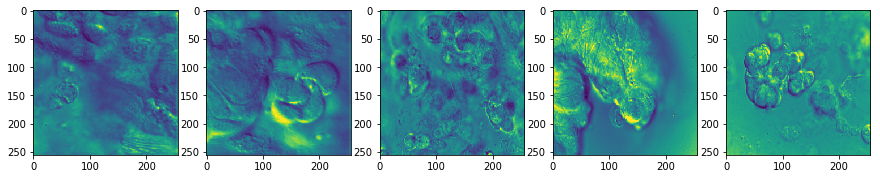

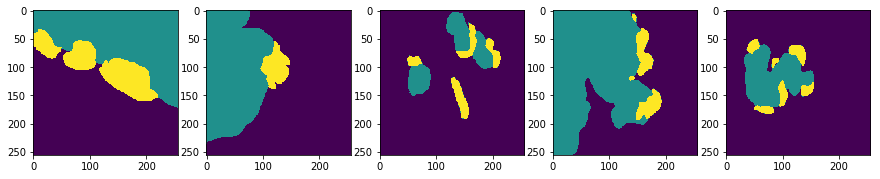

In [37]:
plt.figure(figsize = [15,10])
for i in range(5):
    plt.subplot(1,5,i+1)
    imgplot = plt.imshow(train_df.resized_imgs[i][0])
plt.figure(figsize = [15,10])
for i in range(5):
    plt.subplot(1,5,i+1)
    imgplot = plt.imshow(np.mean(train_df.resized_masks[i],axis = 2))    

In [7]:
from sklearn.model_selection import train_test_split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(train_df.resized_imgs, train_df.resized_masks, test_size=0.33)

In [41]:
print np.stack(X_train,axis=0).shape
print np.stack(y_train,axis=0).shape
print np.array(X_test).shape
print np.array(y_test).shape


(141, 100, 256, 256)
(141, 256, 256, 3)
(70, 100, 256, 256)
(70, 256, 256, 3)


# lstm implementation

In [42]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.utils import to_categorical

/Applications/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
model = Sequential()
#model.add(Embedding(max_features, output_dim=256))
model.add(LSTM(180, return_sequences=True, input_shape=(X_train_set.shape[1], X_train_set.shape[2]),activation='tanh'))
model.add(LSTM(64,return_sequences=True,activation='tanh'))
model.add(LSTM(32,activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

In [12]:
#feature extraction

# Calculate the std of all trainings
train_df.std = [np.std(x, axis=0) for x in train_df.images]



In [13]:
def std_thresholding(std_image,threshold):
    '''
    input: std_image: the std of the images in a sample
        threshold: threshold of std, if std > threshold then assigned as celia (label as 2)
    output: predicted_mask
    '''
    predicted_mask = np.array([[2 if x > threshold else 0 for x in line] for line in std_image])
    return predicted_mask

In [19]:
# Generating predicted masks
threshold = 5
train_df.pred_mask = [std_thresholding(x,threshold) for x in train_df.std]


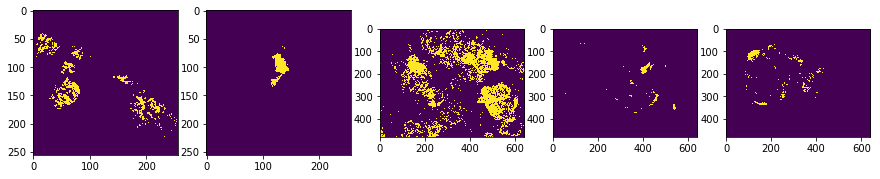

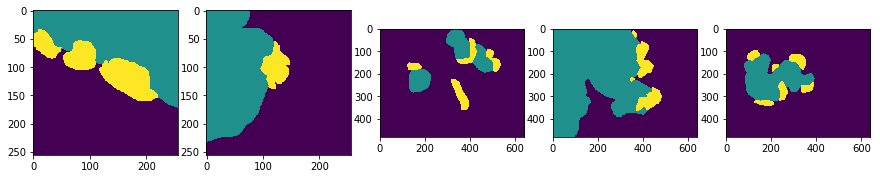

In [20]:
# Visualization of the first 5 samples
plt.figure(figsize = [15,10])
for i in range(5):
    plt.subplot(1,5,i+1)
    imgplot = plt.imshow(train_df.pred_mask[i])
plt.figure(figsize = [15,10])
for i in range(5):    
    plt.subplot(1,5,i+1)
    imgplot = plt.imshow(np.mean(train_df.mask[i],axis = 2))

In [18]:
train_df.mask[0]

array([[[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

# Below are testing code

In [21]:
# Testing

test_hash = read_file(TEST_FILE)

In [24]:
# downloading testing data

import subprocess
for i in range(len(test_hash)):
    subprocess.call("../../google-cloud-sdk/bin/gsutil cp gs://uga-dsp/project2/data/" + test_hash[i] + ".tar " + DATA_DIR, shell=True)


import tarfile
for i in range(len(test_hash)):
    tar=tarfile.open(DATA_DIR + test_hash[i] + ".tar")
    tar.extractall("../")
    tar.close()

In [46]:
# Reading images

test_df = pd.DataFrame(test_hash,columns=['Hash_code'])
# test_df.mask = [cv.imread(MASK_DIR + x + ".png") for x in train_df.Hash_code]
test_df['images'] = [get_image(x) for x in test_df['Hash_code']]

In [47]:
#feature extraction

# Calculate the std of all trainings
test_df['std'] = [np.std(x, axis=0) for x in test_df['images']]

# Generating predicted masks
threshold = 5
test_df['pred_mask'] = [std_thresholding(x,threshold) for x in test_df['std']]

In [52]:
# Output the result
if not os.path.isdir(RESULT_DIR):
    os.mkdir(RESULT_DIR)
    
import scipy.misc
for index, test_sample in test_df.iterrows():
    cv.imwrite(RESULT_DIR+ test_sample['Hash_code'] + '.png', test_sample['pred_mask'])



"\nfor test_sample in test_df:\n    scipy.misc.imsave(RESULT_DIR+ test_sample.Hash_code + '.png', test_sample.pred_mask)\n"